In [402]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import yfinance as yf
import math as m
from scipy.stats import norm
from scipy.optimize import minimize

In [403]:
total = 3 * 365
port = ['MS','MSFT','GOOG','JPM']

In [404]:
def get_data(tickers : list, days = total):
    '''Inputs: tickers -> list of stocks for portfolio ; days -> amount for stock's history.
    Returns a dictionary of the stocks with the necessary data for Monte Carlo Simulations'''
    end = dict()
    closes = dict()
    date_start = dt.date.today() - dt.timedelta(days = days)
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        data = stock.history(start = date_start)
        data = data.drop(columns=['Volume','Dividends','Stock Splits','Open','High','Low']) 
        data["Percent Change"] = data["Close"].pct_change() 
        data["Log Change"] = np.log(data['Percent Change'] + 1)
        end[ticker] = data
        closes[ticker] = data['Close'][-1]
    return end, closes

def df_log_changes(data: dict):
    end = pd.DataFrame(index=data[list(data.keys())[0]].index)
    for ticker in data:
        end[ticker] = data[ticker]['Log Change']
    return end

def random_weights(assets:int, num = 10000):
    end = np.random.uniform(0,1,size=(num,assets))
    sums = np.sum(end,axis=1)
    end = end / sums[:,np.newaxis] #scale for sum of each to be equal to 1
    return end


In [405]:
def Port_GBM(data: dict, weights: np.ndarray, num = 10000, days = 252, intiial_value = 1000):
    percent_changes_df = pd.DataFrame(index=data[list(data.keys())[0]].index)
    for ticker in data:
        percent_changes_df[ticker] = data[ticker]['Percent Change']
    
    means = percent_changes_df.mean()
    covMatrix = percent_changes_df.cov()
    cholesky = np.linalg.cholesky(covMatrix)
    
    meansMatrix = np.full(shape=(days,len(weights)),fill_value=means)
    meansMatrix = meansMatrix.T

    end = np.full(shape=(days + 1, num), fill_value= 0.0)
    end[0] = intiial_value

    for i in range(num):
        normal = np.random.normal(size = (days , len(weights)))
        returns = meansMatrix + np.inner(cholesky,normal) #inner product is dot product of each row cholesky to each row of normal is equal to cholesky @ normal.T
        end[1:,i] = np.cumprod(np.inner(weights, returns.T) + 1) * intiial_value

    return pd.DataFrame(end)

def port_exp_vol(weights: np.ndarray, expected_array : np.ndarray, covariance: np.ndarray):
    expected = np.sum(weights * expected_array, axis= 1) #sum weight * expected_hist_return
    vols = []
    for i in range(len(weights)):
        vols.append(weights[i].T @ covariance @ weights[i])
    return expected, np.sqrt(np.array(vols))

def avg_returns(log_changes: pd.DataFrame):
    '''Gives YEARLY historical expected returns. Given by daily expected * 252'''
    end = dict()
    for ticker in log_changes.columns.tolist():
        end[ticker] = np.mean(log_changes[ticker]) * 252
    return end

In [406]:
def Sharpe_ratio_negative(weights, expected, covariance, r = 4.12/100):
    expected = np.sum(weights * expected) #sum weight * expected_hist_return
    vol = np.sqrt(weights.T @ covariance @ weights)
    ratio = (expected - r) / vol
    return -ratio

def max_min_sharpe(weights, expected, vol, r = 4.12/100):
    sharpe = (expected - r) / vol
    max_sharpe = np.argmax(sharpe)
    max_weights = weights[max_sharpe]
    min_sharpe = np.argmin(sharpe)
    min_weighs = weights[min_sharpe]
    return max_weights, min_weighs

def sum_one(weights):
    return np.sum(weights) - 1

def plot_frontier(expected_returns: np.ndarray, volatilities: np.ndarray, r = 4.12/100):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, expected_returns, c = (expected_returns - r) / volatilities)
    plt.title('Portfolio Frontier')
    plt.xlabel('Portfolio Volatility')
    plt.ylabel('Portfolio Expected Return')
    plt.colorbar(label = 'Sharpe Ratio')
    plt.grid(True)
    plt.show()

In [407]:
def ProbabilityOver(results,initial):
    np.array(initial)
    initial = round(initial,2)
    print(f"Probabilty over initial value ({initial}) by count: {np.count_nonzero(results > initial)/len(results)}")

def VaR_CVaR(results: pd.Series, intial: float, r : float = 10):
    value_r = round(np.percentile(results,r),2)
    

    mean_r = round(np.mean([x for x in results if x <= value_r]),2)

    print('\n')
    print(f'Value at which {r}% of predictions fall under by results: {value_r}')
    print(f'Expected price of lower {r}%: {mean_r}')
    if mean_r - intial < 0:
        print(f'Expected loss: {round(abs(mean_r - intial),2)}') #E[X - last_close] = E[X] - last_close, where X is the resuults under VaR
    else:
        print(f'Expected gain: {round(abs(mean_r - intial),2)}')

In [408]:
data, closes = get_data(port)
log_changes = df_log_changes(data)
covariance = log_changes.cov()
year_cov = covariance * 252
cholesky_decom = np.linalg.cholesky(year_cov)
year_expected = avg_returns(log_changes)
year_expected_array = [year_expected[ticker] for ticker in year_expected]
dailey_expected = [i/252 for i in year_expected_array]
weights = random_weights(len(port))

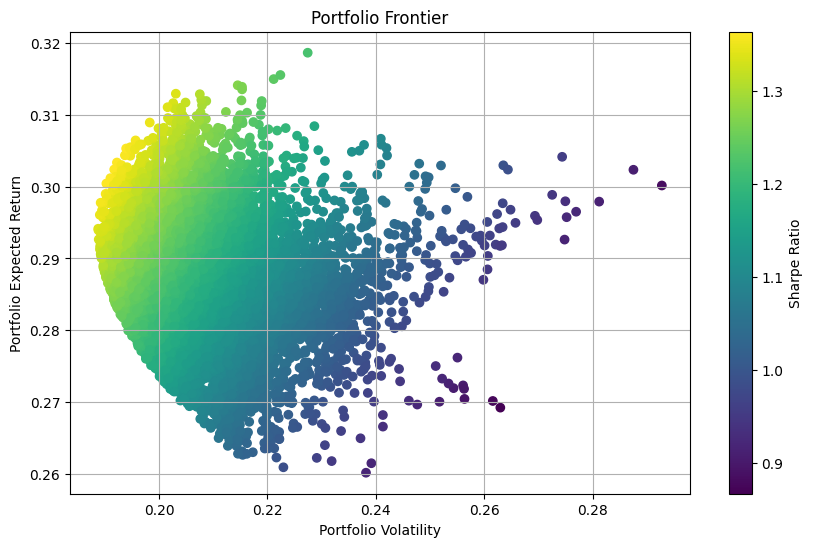

In [409]:
expected_return, vol = port_exp_vol(weights,year_expected_array,year_cov)
plot_frontier(expected_return,vol)
max_sharpe, min_sharpe = max_min_sharpe(weights,expected_return,vol)

In [410]:
best = minimize(Sharpe_ratio_negative,np.array([1/len(port)] * len(port)),args= (year_expected_array,year_cov,4.12/100),method='SLSQP',bounds=((0,1),)*len(port), constraints= ({'type':'eq','fun':sum_one}))

In [411]:
print(f'Monte Carlo Max Sharpe Ratio weights:')
for i in range(len(port)):
    print(f'{port[i]}: {round(100 * max_sharpe[i],2)}')
print(f'with a ratio of {-Sharpe_ratio_negative(max_sharpe,year_expected_array,year_cov)}')
print('\n')

print(f'Monte Carlo Min Sharpe Ratio weights:')
for i in range(len(port)):
    print(f'{port[i]}: {round(100 * min_sharpe[i],2)}')
print(f'with a ratio of {-Sharpe_ratio_negative(min_sharpe,year_expected_array,year_cov)}')

print('\n')
print(f'Minimize Max Sharpe Ratio weights:')
for i in range(len(port)):
    print(f'{port[i]}: {round(100 * best.x[i],2)}')
print(f'with a ratio of {-Sharpe_ratio_negative(best.x,year_expected_array,year_cov)}')
print('\n')

Monte Carlo Max Sharpe Ratio weights:
MS: 0.17
MSFT: 20.95
GOOG: 17.95
JPM: 60.92
with a ratio of 1.3635827334429418


Monte Carlo Min Sharpe Ratio weights:
MS: 90.72
MSFT: 0.98
GOOG: 8.19
JPM: 0.1
with a ratio of 0.8673140458933818


Minimize Max Sharpe Ratio weights:
MS: 0.0
MSFT: 22.06
GOOG: 15.54
JPM: 62.41
with a ratio of 1.3647842490543363




In [412]:
intitial_price = sum(closes[ticker] * best.x[i] for i, ticker in enumerate(port))
port_sim = Port_GBM(data,best.x, intiial_value = intitial_price)

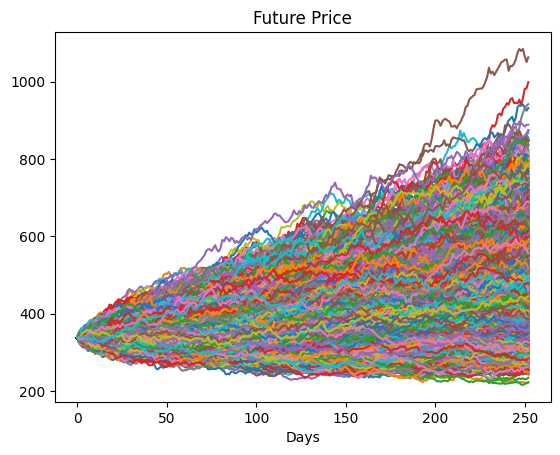

In [413]:
port_sim.plot(legend=False)
plt.title("Future Price")
plt.xlabel("Days")
plt.show()


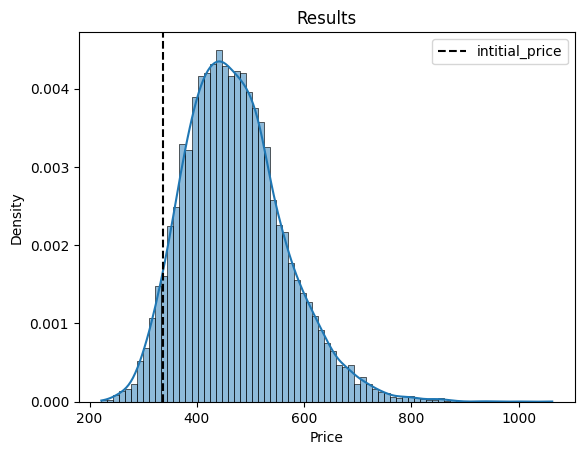

In [414]:
sns.histplot(np.array(np.array(port_sim.iloc[-1])), kde= True, bins='auto', stat='density')
plt.axvline(x = intitial_price, color = 'black', linestyle = '--', label = "intitial_price")
plt.title("Results")
plt.xlabel("Price")
plt.legend()
plt.show()

In [415]:
ProbabilityOver(port_sim.iloc[-1], intitial_price)
VaR_CVaR(port_sim.iloc[-1],intitial_price, 10)

Probabilty over initial value (337.59) by count: 0.9453


Value at which 10% of predictions fall under by results: 359.57
Expected price of lower 10%: 328.97
Expected loss: 8.62
